# Study an integral

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$y(x) = \frac{1}{10} \left( \frac{\lg(x)}{2} \right)^{\sin(x)}$$
$$\int_{16.5}^{27} \frac{1}{10} \left( \frac{\lg(x)}{2} \right)^{\sin(x)} \,dx = 1.09613$$

In [2]:
def y(x):
    return (1 / 10) * (np.log(x) / 2) ** np.sin(x)

analytical_ans = 1.09613

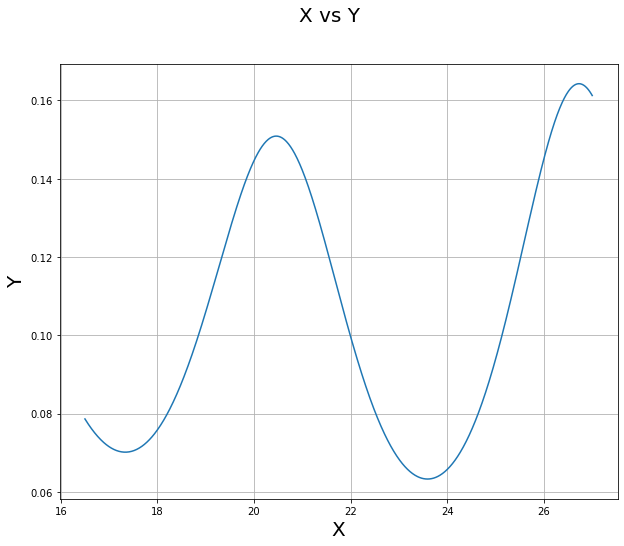

In [3]:
x_mass = np.linspace(16.5, 27, 1000)
y_mass = y(x_mass)

plt.figure(figsize=(10, 8))
plt.plot(x_mass, y_mass)
plt.xlabel('X', fontsize=20)
plt.ylabel('Y', fontsize=20)
plt.suptitle('X vs Y', fontsize=20)
plt.grid(True)

In [4]:
def trapezoidal_rule_integration(lower_bound, upper_bound, discretization=1):    
    samples = np.arange(lower_bound, upper_bound, discretization)
    return (discretization * (y(samples) + y(samples + discretization)) / 2).sum()

$$\text{SE} = \left(Y - \hat{Y}\right)^2$$

In [15]:
squared_error = []
steps = np.arange(0.001, 1.00001, 0.001)
for d in steps:
    squared_error.append(np.abs(trapezoidal_rule_integration(16.5, 27, d) - analytical_ans))

Text(0.5, 0.98, 'Integration error vs discretization size')

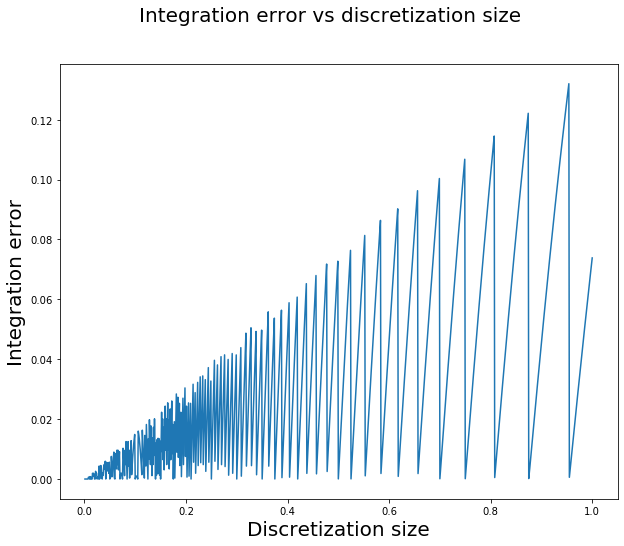

In [17]:
plt.figure(figsize=(10, 8))
plt.plot(steps, squared_error)
plt.xlabel('Discretization size', fontsize=20)
plt.ylabel('Integration error', fontsize=20)
plt.suptitle('Integration error vs discretization size', fontsize=20)

### MPI

In [7]:
%%writefile task_07_integral.py

import os
import time
import numpy as np

from PIL import Image
from mpi4py import MPI


def y(x):
    return (1 / 10) * (np.log(x) / 2) ** np.sin(x)

def trapezoidal_rule_integration(samples, discretization):
    summ = 0
    for s in samples:
        summ += discretization * (y(s) + y(s + discretization)) / 2
    return summ


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

IS_ROOT = rank == 0
IS_SAVE = False

LOWER_BOUND = 16.5
UPPER_BOUND = 27
DISCRETIZATION = 0.000001

if IS_ROOT:
    samples = np.arange(LOWER_BOUND, UPPER_BOUND, DISCRETIZATION, dtype=float)
    array_size = samples.size
else:
    samples = None
    array_size = None
    
array_size = comm.bcast(array_size, root=0)
num_data_per_rank = array_size // size

if IS_ROOT:
    num_data_per_rank =  array_size - (num_data_per_rank * (size - 1))

received = np.empty(num_data_per_rank, dtype=float)
sendcounts = np.array(comm.gather(num_data_per_rank, 0))

comm.Scatterv((samples, sendcounts), received, root=0)
received_calc = trapezoidal_rule_integration(received, DISCRETIZATION)

answer = comm.reduce(received_calc, op=MPI.SUM, root=0)

Overwriting task_07_integral.py


In [8]:
time_arr = []
processes = range(1, 12)
for i in processes:
    print(f'{i} process(es)\n\t', end='')
    t = %timeit -o -r 3 !mpirun -n {i} --allow-run-as-root --mca btl ^vader python3 task_07_integral.py
    time_arr.append(t.best)

1 process(es)
	51.8 s ± 321 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
2 process(es)
	26.6 s ± 226 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
3 process(es)
	18.6 s ± 63.3 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)
4 process(es)
	^C


KeyboardInterrupt: 

In [ ]:
speedup = time_arr[0] / np.array(time_arr)

plt.figure(figsize=(10, 8))
plt.plot(processes, speedup)
plt.xticks(processes)
plt.xlabel('Num of processes', fontsize=20)
plt.ylabel('SpeedUp = T(1)/T(n)', fontsize=20)
plt.suptitle('SpeedUp vs Num of processes', fontsize=20)